# 🔬 Phase 1 Experiment 2: Gate Ablation via Clamping

**What we're doing:** Taking the pretrained gated models and forcibly overriding gate scores
at inference time, then measuring how much the model's quality degrades.

**Why this is novel:** The paper never does this. They only report what the gates look like —
they never ask "what happens if I break specific gates?" This tells us:
1. Which layers' gates contribute most to performance
2. Which heads can be safely pruned (gate=0 with no quality loss)
3. Whether gates are more important in early/middle/late layers
4. Whether forcing all gates fully open (gate=1, effectively removing gating)
   degrades to baseline-level performance

**Method:** We use PyTorch forward hooks to intercept and replace gate scores
during the forward pass. We measure quality using **perplexity** (PPL) —
lower is better, and any increase means the model got worse.

**Requirements:** Colab T4 GPU, ~30 min total runtime.

## Step 0: Install Dependencies

In [1]:
!pip install -q transformers==4.51.0 torch matplotlib numpy seaborn pandas datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.1 MB/s eta 0:00:00


In [2]:
# Clone the model repo (skip if already done from Experiment 1)
import os
if not os.path.exists("/content/gated_attention"):
    !git lfs install
    !git clone https://huggingface.co/QwQZh/gated_attention /content/gated_attention
else:
    print("Repo already cloned.")

# Make sure LFS files are pulled for the models we need
!cd /content/gated_attention && git lfs pull --include="1B_gate_headwise/*"
!cd /content/gated_attention && git lfs pull --include="1B_baseline/*"

Git LFS initialized.
Cloning into '/content/gated_attention'...
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25 (from 1)
Receiving objects: 100% (25/25), 3.08 MiB | 3.27 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Filtering content: 100% (3/3), 9.63 GiB | 36.42 MiB/s, done.


In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from datasets import load_dataset
from collections import defaultdict
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: Tesla T4
VRAM: 15.6 GB


## Step 1: Load Model

In [4]:
LOCAL_DIR = "/content/gated_attention"

def load_model(variant_name):
    path = f"{LOCAL_DIR}/1B_{variant_name}"
    print(f"Loading {variant_name} from {path}...")

    tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        path,
        trust_remote_code=True,
        attn_implementation="eager",
        torch_dtype=torch.float16,
    ).to(device).eval()

    config = model.config
    print(f"  headwise_attn_output_gate: {getattr(config, 'headwise_attn_output_gate', False)}")
    print(f"  elementwise_attn_output_gate: {getattr(config, 'elementwise_attn_output_gate', False)}")
    print(f"  num_attention_heads: {config.num_attention_heads}")
    print(f"  num_hidden_layers: {config.num_hidden_layers}")
    print(f"  Loaded successfully!\n")
    return model, tokenizer

model_hw, tokenizer_hw = load_model("gate_headwise")

Loading gate_headwise from /content/gated_attention/1B_gate_headwise...


You are using a model of type qwen2 to instantiate a model of type qwen3. This is not supported for all configurations of models and can yield errors.


  headwise_attn_output_gate: True
  elementwise_attn_output_gate: False
  num_attention_heads: 16
  num_hidden_layers: 28
  Loaded successfully!



## Step 2: Prepare Evaluation Data

We use a subset of **WikiText-2** to measure perplexity.
This is a standard LM evaluation dataset. We concatenate text into chunks
of a fixed sequence length so perplexity is comparable across runs.

In [5]:
def prepare_eval_data(tokenizer, seq_length=512, num_samples=50):
    """Load WikiText-2 test set and prepare fixed-length chunks for PPL evaluation.

    Args:
        tokenizer: The model's tokenizer
        seq_length: Length of each evaluation chunk
        num_samples: How many chunks to evaluate on (more = more accurate but slower)

    Returns:
        List of input_ids tensors, each of shape [1, seq_length]
    """
    print("Loading WikiText-2 test set...")
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")

    # Concatenate all text
    full_text = "\n\n".join([t for t in dataset["text"] if t.strip()])
    print(f"Total text length: {len(full_text)} characters")

    # Tokenize the entire text
    encodings = tokenizer(full_text, return_tensors="pt")
    total_tokens = encodings.input_ids.shape[1]
    print(f"Total tokens: {total_tokens}")

    # Split into non-overlapping chunks
    chunks = []
    for i in range(0, total_tokens - seq_length, seq_length):
        chunk = encodings.input_ids[:, i:i + seq_length]
        chunks.append(chunk)
        if len(chunks) >= num_samples:
            break

    print(f"Prepared {len(chunks)} chunks of {seq_length} tokens each")
    return chunks

eval_chunks = prepare_eval_data(tokenizer_hw, seq_length=512, num_samples=50)

Loading WikiText-2 test set...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Total text length: 1291402 characters


Token indices sequence length is longer than the specified maximum sequence length for this model (298938 > 131072). Running this sequence through the model will result in indexing errors


Total tokens: 298938
Prepared 50 chunks of 512 tokens each


## Step 3: Perplexity Measurement Function

In [6]:
@torch.no_grad()
def measure_perplexity(model, eval_chunks, device):
    """Compute perplexity on evaluation chunks.

    Perplexity = exp(average cross-entropy loss).
    Lower is better. A model with PPL=10 is roughly choosing between
    10 equally likely next tokens on average.

    Returns:
        float: perplexity score
    """
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    for chunk in eval_chunks:
        input_ids = chunk.to(device)
        # Targets are the input shifted by one position
        # The model predicts token[i+1] given token[0:i]
        outputs = model(input_ids=input_ids, labels=input_ids)
        loss = outputs.loss  # Cross-entropy loss averaged over sequence
        seq_len = input_ids.shape[1]

        total_loss += loss.item() * seq_len
        total_tokens += seq_len

    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)
    return perplexity

# Measure baseline perplexity of the unmodified gated model
print("Measuring baseline perplexity (no clamping)...")
start = time.time()
baseline_ppl = measure_perplexity(model_hw, eval_chunks, device)
elapsed = time.time() - start
print(f"Baseline PPL (headwise gated, unmodified): {baseline_ppl:.2f}")
print(f"Time: {elapsed:.1f}s")

Measuring baseline perplexity (no clamping)...
Baseline PPL (headwise gated, unmodified): 12.39
Time: 7.4s


## Step 4: The Gate Clamping Hook

This is the core tool. We create hooks that intercept the `q_proj` output
and **replace** the gate score portion with a fixed value.

From the verified source code, we know:
- `q_proj` outputs `[batch, seq_len, num_heads * head_dim + num_heads]` for headwise
- After `view(bsz, q_len, num_kv_heads, -1)`, the last `num_kv_groups` values per KV group are gate scores
- These go through `sigmoid` later in the forward pass

So to clamp the gate to a target value `v` (post-sigmoid), we need to set
the raw gate scores to `sigmoid_inverse(v)` = `log(v / (1-v))`.

In [7]:
class GateClampingHook:
    """Intercepts q_proj output and clamps gate scores to a fixed value.

    Can target specific layers and/or specific heads.

    Args:
        model: The gated attention model
        clamp_value: The desired post-sigmoid gate value (0.0 to 1.0).
                     0.0 = force gate fully closed (kill the head's output)
                     1.0 = force gate fully open (as if no gating)
        target_layers: List of layer indices to clamp, or None for all layers
        target_heads: List of head indices to clamp within targeted layers,
                      or None for all heads
    """

    def __init__(self, model, clamp_value, target_layers=None, target_heads=None):
        self.model = model
        self.config = model.config
        self.hooks = []

        self.num_heads = self.config.num_attention_heads
        self.num_kv_heads = self.config.num_key_value_heads
        self.num_kv_groups = self.num_heads // self.num_kv_heads
        self.head_dim = self.config.head_dim
        self.num_layers = self.config.num_hidden_layers

        self.target_layers = target_layers  # None = all
        self.target_heads = target_heads    # None = all heads in targeted layers

        # Convert desired post-sigmoid value to pre-sigmoid (raw) value
        # sigmoid(x) = v  =>  x = log(v / (1-v))
        # Clamp to avoid inf: sigmoid(-20) ≈ 0, sigmoid(20) ≈ 1
        clamped = max(min(clamp_value, 0.9999999), 0.0000001)
        self.raw_clamp_value = np.log(clamped / (1 - clamped))
        self.clamp_value = clamp_value

        self._register_hooks()

    def _register_hooks(self):
        for layer_idx, layer in enumerate(self.model.model.layers):
            # Skip layers we're not targeting
            if self.target_layers is not None and layer_idx not in self.target_layers:
                continue

            q_proj = layer.self_attn.q_proj
            hook = q_proj.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hooks.append(hook)

    def _make_hook(self, layer_idx):
        """Create a hook that replaces gate scores in q_proj output."""
        raw_val = self.raw_clamp_value
        num_kv_heads = self.num_kv_heads
        num_kv_groups = self.num_kv_groups
        head_dim = self.head_dim
        target_heads = self.target_heads

        def hook_fn(module, input, output):
            # output: [batch, seq_len, num_heads * head_dim + num_heads]
            bsz, q_len, _ = output.size()

            # Reshape the same way as modeling_qwen3.py
            reshaped = output.view(bsz, q_len, num_kv_heads, -1)
            # reshaped: [batch, seq_len, num_kv_heads, head_dim * num_kv_groups + num_kv_groups]

            query_part_size = head_dim * num_kv_groups
            gate_part_size = num_kv_groups

            # Split into queries and gate scores
            queries = reshaped[..., :query_part_size]
            gate_raw = reshaped[..., query_part_size:]
            # gate_raw: [batch, seq_len, num_kv_heads, num_kv_groups]

            if target_heads is not None:
                # Only clamp specific heads
                # gate_raw has shape [batch, seq_len, num_kv_heads, num_kv_groups]
                # Each KV head has num_kv_groups query heads
                # Head i belongs to KV group (i // num_kv_groups), position (i % num_kv_groups)
                for head_idx in target_heads:
                    kv_idx = head_idx // num_kv_groups
                    group_pos = head_idx % num_kv_groups
                    gate_raw[:, :, kv_idx, group_pos] = raw_val
            else:
                # Clamp ALL gate scores in this layer
                gate_raw = torch.full_like(gate_raw, raw_val)

            # Reconstruct the output
            modified = torch.cat([queries, gate_raw], dim=-1)
            return modified.view(bsz, q_len, -1)

        return hook_fn

    def remove(self):
        """Remove all hooks to restore normal model behavior."""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []


print("GateClampingHook defined.")

GateClampingHook defined.


## Step 5: Experiment A — Force ALL Gates Open (gate=1.0)

If gating is truly helping, forcing all gates to 1.0 (fully open = no filtering)
should degrade performance. This effectively turns the gated model into a model
that has gating parameters but ignores them.

**Prediction:** PPL should increase significantly (worse). If it doesn't,
the gates aren't doing anything useful at inference time.

In [8]:
# Force all gates to 1.0 (fully open = effectively remove gating)
print("=" * 60)
print("Experiment A: Force ALL gates to 1.0 (fully open)")
print("=" * 60)

hook_all_open = GateClampingHook(model_hw, clamp_value=1.0, target_layers=None)
ppl_all_open = measure_perplexity(model_hw, eval_chunks, device)
hook_all_open.remove()

print(f"\nBaseline PPL (normal gating):  {baseline_ppl:.2f}")
print(f"All gates=1.0 PPL:             {ppl_all_open:.2f}")
print(f"Degradation:                   +{ppl_all_open - baseline_ppl:.2f} ({(ppl_all_open/baseline_ppl - 1)*100:.1f}%)")

Experiment A: Force ALL gates to 1.0 (fully open)

Baseline PPL (normal gating):  12.39
All gates=1.0 PPL:             251076.01
Degradation:                   +251063.62 (2026608.7%)


In [9]:
# Force all gates to 0.0 (fully closed = kill all attention output)
print("=" * 60)
print("Experiment A (cont): Force ALL gates to 0.0 (fully closed)")
print("=" * 60)

hook_all_closed = GateClampingHook(model_hw, clamp_value=0.0, target_layers=None)
ppl_all_closed = measure_perplexity(model_hw, eval_chunks, device)
hook_all_closed.remove()

print(f"\nBaseline PPL (normal gating):  {baseline_ppl:.2f}")
print(f"All gates=1.0 PPL:             {ppl_all_open:.2f}")
print(f"All gates=0.0 PPL:             {ppl_all_closed:.2f}")
print(f"\nNote: gates=0.0 should be catastrophic — it kills ALL attention output.")

Experiment A (cont): Force ALL gates to 0.0 (fully closed)

Baseline PPL (normal gating):  12.39
All gates=1.0 PPL:             251076.01
All gates=0.0 PPL:             303654.36

Note: gates=0.0 should be catastrophic — it kills ALL attention output.


In [10]:
# Force all gates to the mean value found by the paper (0.116)
# This tests: does the input-DEPENDENT part of gating matter,
# or would a fixed gate at the average level work just as well?
print("=" * 60)
print("Experiment A (cont): Force ALL gates to 0.116 (paper's mean)")
print("=" * 60)

hook_mean = GateClampingHook(model_hw, clamp_value=0.116, target_layers=None)
ppl_mean = measure_perplexity(model_hw, eval_chunks, device)
hook_mean.remove()

print(f"\nBaseline PPL (learned gates):    {baseline_ppl:.2f}")
print(f"All gates=1.0 PPL (no gating):   {ppl_all_open:.2f}")
print(f"All gates=0.116 PPL (fixed mean): {ppl_mean:.2f}")
print(f"All gates=0.0 PPL (all closed):   {ppl_all_closed:.2f}")
print(f"\nIf fixed-mean PPL ≈ baseline: the SPARSITY LEVEL matters but not the pattern.")
print(f"If fixed-mean PPL >> baseline: the INPUT-DEPENDENT PATTERN matters, not just sparsity.")

Experiment A (cont): Force ALL gates to 0.116 (paper's mean)

Baseline PPL (learned gates):    12.39
All gates=1.0 PPL (no gating):   251076.01
All gates=0.116 PPL (fixed mean): 276.97
All gates=0.0 PPL (all closed):   303654.36

If fixed-mean PPL ≈ baseline: the SPARSITY LEVEL matters but not the pattern.
If fixed-mean PPL >> baseline: the INPUT-DEPENDENT PATTERN matters, not just sparsity.


## Step 6: Experiment B — Layer-by-Layer Ablation

Force gates open one layer at a time. The layer that causes the biggest PPL increase
when its gates are forced open is the layer where gating is most critical.

This takes ~15 min (one PPL eval per layer × number of layers).

In [11]:
print("=" * 60)
print("Experiment B: Layer-by-layer ablation (force gates=1.0 per layer)")
print("=" * 60)

num_layers = model_hw.config.num_hidden_layers
layer_ablation_results = {}

for layer_idx in range(num_layers):
    hook = GateClampingHook(model_hw, clamp_value=1.0, target_layers=[layer_idx])
    ppl = measure_perplexity(model_hw, eval_chunks, device)
    hook.remove()

    delta = ppl - baseline_ppl
    layer_ablation_results[layer_idx] = {
        'ppl': ppl,
        'delta': delta,
        'pct_change': (ppl / baseline_ppl - 1) * 100
    }
    print(f"  Layer {layer_idx:2d}: PPL={ppl:.2f}  (Δ={delta:+.2f}, {(ppl/baseline_ppl-1)*100:+.1f}%)")

print(f"\nDone! Baseline PPL: {baseline_ppl:.2f}")

Experiment B: Layer-by-layer ablation (force gates=1.0 per layer)
  Layer  0: PPL=148419.23  (Δ=+148406.84, +1197953.7%)
  Layer  1: PPL=245.62  (Δ=+233.23, +1882.6%)
  Layer  2: PPL=97.92  (Δ=+85.53, +690.4%)
  Layer  3: PPL=20.39  (Δ=+8.00, +64.6%)
  Layer  4: PPL=22.28  (Δ=+9.90, +79.9%)
  Layer  5: PPL=16.38  (Δ=+3.99, +32.2%)
  Layer  6: PPL=13.87  (Δ=+1.48, +12.0%)
  Layer  7: PPL=13.56  (Δ=+1.17, +9.4%)
  Layer  8: PPL=13.12  (Δ=+0.73, +5.9%)
  Layer  9: PPL=13.04  (Δ=+0.65, +5.2%)
  Layer 10: PPL=14.57  (Δ=+2.18, +17.6%)
  Layer 11: PPL=13.51  (Δ=+1.12, +9.1%)
  Layer 12: PPL=13.34  (Δ=+0.95, +7.7%)
  Layer 13: PPL=13.26  (Δ=+0.87, +7.1%)
  Layer 14: PPL=13.41  (Δ=+1.02, +8.2%)
  Layer 15: PPL=13.41  (Δ=+1.02, +8.2%)
  Layer 16: PPL=13.95  (Δ=+1.56, +12.6%)
  Layer 17: PPL=13.38  (Δ=+0.99, +8.0%)
  Layer 18: PPL=13.47  (Δ=+1.09, +8.8%)
  Layer 19: PPL=15.86  (Δ=+3.47, +28.0%)
  Layer 20: PPL=14.08  (Δ=+1.69, +13.7%)
  Layer 21: PPL=14.49  (Δ=+2.10, +16.9%)
  Layer 22: PPL=13.53

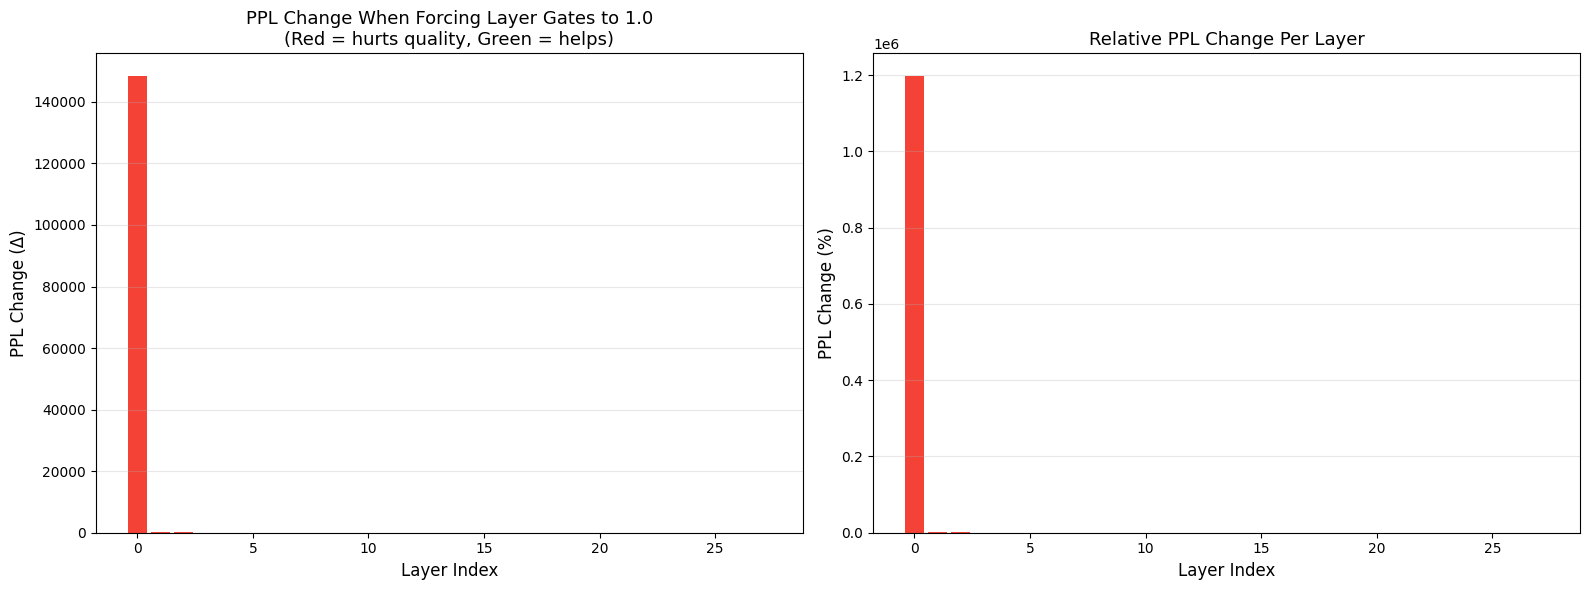


--- Layers Ranked by Gate Importance (most → least critical) ---
 Layer       PPL     Δ PPL  % Change
------------------------------------
     0  148419.23  +148406.84  +1197953.7%
     1    245.62   +233.23  +1882.6%
     2     97.92    +85.53   +690.4%
     4     22.28     +9.90    +79.9%
     3     20.39     +8.00    +64.6%
     5     16.38     +3.99    +32.2%
    19     15.86     +3.47    +28.0%
    10     14.57     +2.18    +17.6%
    21     14.49     +2.10    +16.9%
    20     14.08     +1.69    +13.7%
    16     13.95     +1.56    +12.6%
     6     13.87     +1.48    +12.0%
    23     13.65     +1.26    +10.2%
    24     13.58     +1.20     +9.7%
     7     13.56     +1.17     +9.4%
    22     13.53     +1.14     +9.2%
    11     13.51     +1.12     +9.1%
    18     13.47     +1.09     +8.8%
    27     13.42     +1.03     +8.3%
    14     13.41     +1.02     +8.2%
    15     13.41     +1.02     +8.2%
    17     13.38     +0.99     +8.0%
    12     13.34     +0.95     +7.7%
   

In [12]:
# Visualize layer importance
layers = list(range(num_layers))
deltas = [layer_ablation_results[l]['delta'] for l in layers]
pct_changes = [layer_ablation_results[l]['pct_change'] for l in layers]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute PPL change
ax = axes[0]
colors = ['#F44336' if d > 0.1 else '#4CAF50' if d < -0.1 else '#9E9E9E' for d in deltas]
ax.bar(layers, deltas, color=colors)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xlabel('Layer Index', fontsize=12)
ax.set_ylabel('PPL Change (Δ)', fontsize=12)
ax.set_title('PPL Change When Forcing Layer Gates to 1.0\n(Red = hurts quality, Green = helps)', fontsize=13)
ax.grid(True, alpha=0.3, axis='y')

# Percentage change
ax = axes[1]
ax.bar(layers, pct_changes, color=colors)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xlabel('Layer Index', fontsize=12)
ax.set_ylabel('PPL Change (%)', fontsize=12)
ax.set_title('Relative PPL Change Per Layer', fontsize=13)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('layer_ablation_gates_open.png', dpi=150, bbox_inches='tight')
plt.show()

# Rank layers by importance
sorted_layers = sorted(layer_ablation_results.items(), key=lambda x: x[1]['delta'], reverse=True)
print("\n--- Layers Ranked by Gate Importance (most → least critical) ---")
print(f"{'Layer':>6s}  {'PPL':>8s}  {'Δ PPL':>8s}  {'% Change':>8s}")
print("-" * 36)
for layer_idx, res in sorted_layers:
    print(f"{layer_idx:>6d}  {res['ppl']:>8.2f}  {res['delta']:>+8.2f}  {res['pct_change']:>+7.1f}%")

## Step 7: Experiment C — Head-by-Head Ablation (Top Layers)

For the layers where gating matters most (from Experiment B),
let's drill down: which specific heads are critical?

We force each head's gate to 0.0 (kill it) one at a time and measure PPL.

In [13]:
print("=" * 60)
print("Experiment C: Head-by-head ablation on most important layers")
print("=" * 60)

# Pick the top 3 most important layers from Experiment B
top_layers = [l for l, _ in sorted_layers[:3]]
num_heads = model_hw.config.num_attention_heads

print(f"Testing heads in layers: {top_layers}")
print(f"Num heads per layer: {num_heads}")
print(f"Total ablations: {len(top_layers) * num_heads}\n")

head_ablation_results = {}  # {(layer, head): {'ppl': ..., 'delta': ...}}

for layer_idx in top_layers:
    print(f"Layer {layer_idx}:")
    for head_idx in range(num_heads):
        # Force THIS specific head's gate to 0.0 (kill it)
        hook = GateClampingHook(
            model_hw,
            clamp_value=0.0,
            target_layers=[layer_idx],
            target_heads=[head_idx]
        )
        ppl = measure_perplexity(model_hw, eval_chunks, device)
        hook.remove()

        delta = ppl - baseline_ppl
        head_ablation_results[(layer_idx, head_idx)] = {
            'ppl': ppl,
            'delta': delta
        }
        marker = "⚠️" if abs(delta) > 0.5 else "  "
        print(f"  Head {head_idx:2d}: PPL={ppl:.2f} (Δ={delta:+.2f}) {marker}")
    print()

Experiment C: Head-by-head ablation on most important layers
Testing heads in layers: [0, 1, 2]
Num heads per layer: 16
Total ablations: 48

Layer 0:
  Head  0: PPL=12.41 (Δ=+0.02)   
  Head  1: PPL=12.41 (Δ=+0.02)   
  Head  2: PPL=12.44 (Δ=+0.05)   
  Head  3: PPL=12.50 (Δ=+0.11)   
  Head  4: PPL=12.69 (Δ=+0.30)   
  Head  5: PPL=12.42 (Δ=+0.03)   
  Head  6: PPL=12.40 (Δ=+0.01)   
  Head  7: PPL=12.37 (Δ=-0.02)   
  Head  8: PPL=12.40 (Δ=+0.01)   
  Head  9: PPL=12.41 (Δ=+0.02)   
  Head 10: PPL=12.43 (Δ=+0.04)   
  Head 11: PPL=12.44 (Δ=+0.05)   
  Head 12: PPL=12.75 (Δ=+0.36)   
  Head 13: PPL=12.40 (Δ=+0.02)   
  Head 14: PPL=12.38 (Δ=-0.01)   
  Head 15: PPL=12.33 (Δ=-0.05)   

Layer 1:
  Head  0: PPL=12.40 (Δ=+0.01)   
  Head  1: PPL=12.33 (Δ=-0.06)   
  Head  2: PPL=12.49 (Δ=+0.10)   
  Head  3: PPL=12.39 (Δ=+0.00)   
  Head  4: PPL=12.37 (Δ=-0.02)   
  Head  5: PPL=12.49 (Δ=+0.10)   
  Head  6: PPL=12.41 (Δ=+0.02)   
  Head  7: PPL=12.47 (Δ=+0.08)   
  Head  8: PPL=12.51 (Δ=

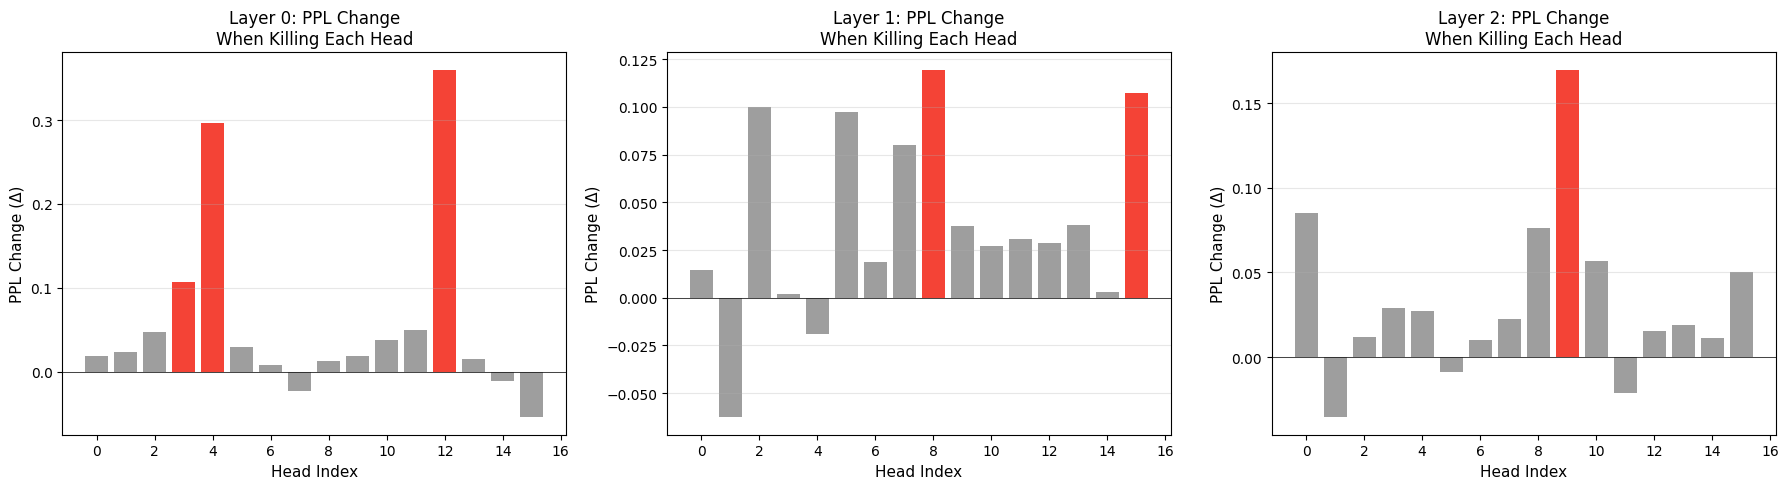


--- Safely Prunable Heads (Δ PPL ≤ 0 when killed) ---
  Layer 1, Head 1: Δ=-0.06 (killing this head HELPS)
  Layer 0, Head 15: Δ=-0.05 (killing this head HELPS)
  Layer 2, Head 1: Δ=-0.04 (killing this head HELPS)
  Layer 0, Head 7: Δ=-0.02 (killing this head HELPS)
  Layer 2, Head 11: Δ=-0.02 (killing this head HELPS)
  Layer 1, Head 4: Δ=-0.02 (killing this head HELPS)
  Layer 0, Head 14: Δ=-0.01 (killing this head HELPS)
  Layer 2, Head 5: Δ=-0.01 (killing this head HELPS)

--- Most Critical Heads (Δ PPL > 0.5 when killed) ---


In [14]:
# Visualize head importance for top layers
fig, axes = plt.subplots(1, len(top_layers), figsize=(6 * len(top_layers), 5))
if len(top_layers) == 1:
    axes = [axes]

for idx, layer_idx in enumerate(top_layers):
    ax = axes[idx]
    head_deltas = [head_ablation_results[(layer_idx, h)]['delta'] for h in range(num_heads)]

    colors = ['#F44336' if d > 0.1 else '#4CAF50' if d < -0.1 else '#9E9E9E' for d in head_deltas]
    ax.bar(range(num_heads), head_deltas, color=colors)
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.set_xlabel('Head Index', fontsize=11)
    ax.set_ylabel('PPL Change (Δ)', fontsize=11)
    ax.set_title(f'Layer {layer_idx}: PPL Change\nWhen Killing Each Head', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('head_ablation_top_layers.png', dpi=150, bbox_inches='tight')
plt.show()

# Find safely prunable heads (killing them doesn't hurt or even helps)
print("\n--- Safely Prunable Heads (Δ PPL ≤ 0 when killed) ---")
prunable = [(l, h, r['delta']) for (l, h), r in head_ablation_results.items() if r['delta'] <= 0]
prunable.sort(key=lambda x: x[2])
for layer, head, delta in prunable:
    print(f"  Layer {layer}, Head {head}: Δ={delta:+.2f} (killing this head HELPS)")

print(f"\n--- Most Critical Heads (Δ PPL > 0.5 when killed) ---")
critical = [(l, h, r['delta']) for (l, h), r in head_ablation_results.items() if r['delta'] > 0.5]
critical.sort(key=lambda x: x[2], reverse=True)
for layer, head, delta in critical:
    print(f"  Layer {layer}, Head {head}: Δ={delta:+.2f} (this head is ESSENTIAL)")

## Step 8: Experiment D — Progressive Gate Opening

What if we gradually force gates from their learned values toward 1.0?
This traces the "path" between the gated model and the effectively-ungated model.

We sweep clamp values: 0.0, 0.1, 0.2, ..., 0.9, 1.0 across ALL layers.

In [15]:
print("=" * 60)
print("Experiment D: Progressive gate sweep (all layers)")
print("=" * 60)

sweep_values = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
sweep_results = {}

for val in sweep_values:
    hook = GateClampingHook(model_hw, clamp_value=val, target_layers=None)
    ppl = measure_perplexity(model_hw, eval_chunks, device)
    hook.remove()

    sweep_results[val] = ppl
    print(f"  gate={val:.2f}: PPL={ppl:.2f}")

# Add the learned-gates baseline
sweep_results['learned'] = baseline_ppl

Experiment D: Progressive gate sweep (all layers)
  gate=0.00: PPL=303654.36
  gate=0.05: PPL=47582.39
  gate=0.10: PPL=620.61
  gate=0.15: PPL=111.60
  gate=0.20: PPL=174.98
  gate=0.30: PPL=9415.31
  gate=0.40: PPL=26572.22
  gate=0.50: PPL=36391.87
  gate=0.70: PPL=62552.87
  gate=1.00: PPL=251076.01


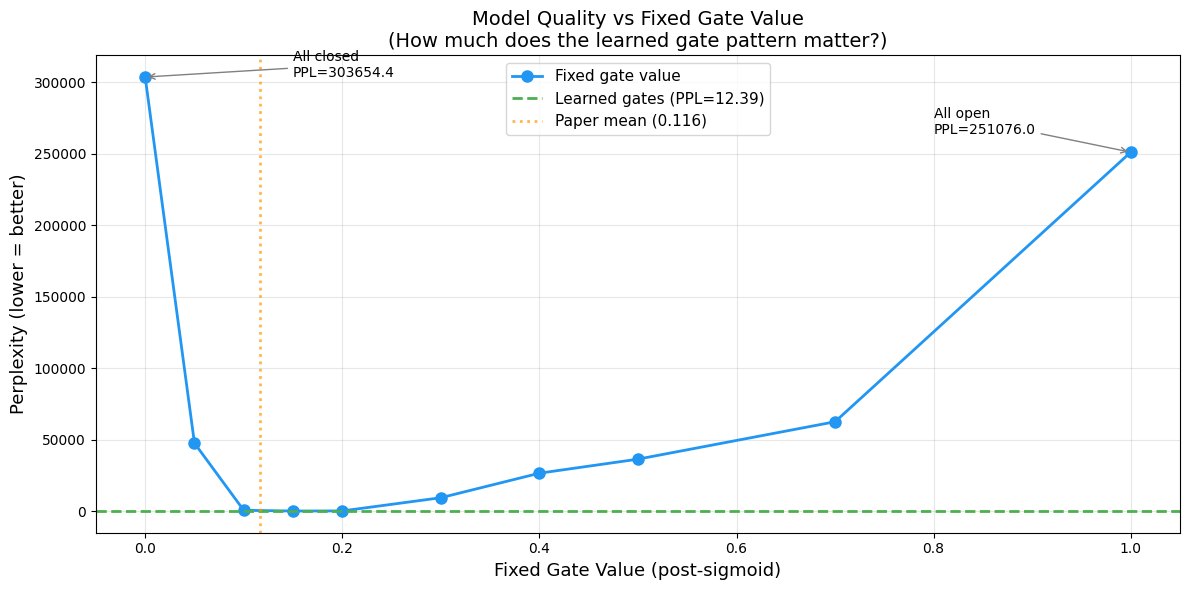


Best fixed gate value: 0.15 → PPL=111.60
Learned gates PPL: 12.39

Gap between best-fixed and learned: 99.21
This gap tells you how much value the INPUT-DEPENDENT pattern adds.


In [16]:
# Plot the sweep
fig, ax = plt.subplots(figsize=(12, 6))

fixed_vals = [v for v in sweep_values]
fixed_ppls = [sweep_results[v] for v in fixed_vals]

ax.plot(fixed_vals, fixed_ppls, 'o-', color='#2196F3', linewidth=2, markersize=8, label='Fixed gate value')
ax.axhline(y=baseline_ppl, color='#4CAF50', linestyle='--', linewidth=2, label=f'Learned gates (PPL={baseline_ppl:.2f})')

# Mark the paper's reported mean
ax.axvline(x=0.116, color='#FF9800', linestyle=':', linewidth=2, alpha=0.7, label='Paper mean (0.116)')

ax.set_xlabel('Fixed Gate Value (post-sigmoid)', fontsize=13)
ax.set_ylabel('Perplexity (lower = better)', fontsize=13)
ax.set_title('Model Quality vs Fixed Gate Value\n(How much does the learned gate pattern matter?)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Annotate key points
ax.annotate(f'All closed\nPPL={sweep_results[0.0]:.1f}',
            xy=(0.0, sweep_results[0.0]), xytext=(0.15, sweep_results[0.0]),
            arrowprops=dict(arrowstyle='->', color='gray'), fontsize=10)
ax.annotate(f'All open\nPPL={sweep_results[1.0]:.1f}',
            xy=(1.0, sweep_results[1.0]), xytext=(0.8, sweep_results[1.0] * 1.05),
            arrowprops=dict(arrowstyle='->', color='gray'), fontsize=10)

plt.tight_layout()
plt.savefig('progressive_gate_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

# Find the optimal fixed value
best_fixed_val = min(sweep_results.items(), key=lambda x: x[1] if isinstance(x[0], float) else float('inf'))
print(f"\nBest fixed gate value: {best_fixed_val[0]:.2f} → PPL={best_fixed_val[1]:.2f}")
print(f"Learned gates PPL: {baseline_ppl:.2f}")
print(f"\nGap between best-fixed and learned: {best_fixed_val[1] - baseline_ppl:.2f}")
print(f"This gap tells you how much value the INPUT-DEPENDENT pattern adds.")

## Step 9: Summary & Interpretation

In [17]:
print("=" * 70)
print("FULL RESULTS SUMMARY")
print("=" * 70)

print(f"\n{'Condition':<45s} {'PPL':>8s} {'Δ':>8s}")
print("-" * 63)
print(f"{'Learned gates (baseline)':.<45s} {baseline_ppl:>8.2f} {0.0:>+8.2f}")
print(f"{'All gates = 1.0 (no gating)':.<45s} {ppl_all_open:>8.2f} {ppl_all_open-baseline_ppl:>+8.2f}")
print(f"{'All gates = 0.116 (fixed at paper mean)':.<45s} {ppl_mean:>8.2f} {ppl_mean-baseline_ppl:>+8.2f}")
print(f"{'All gates = 0.0 (all closed)':.<45s} {ppl_all_closed:>8.2f} {ppl_all_closed-baseline_ppl:>+8.2f}")

print(f"\n--- Key Insights ---")
if ppl_all_open > baseline_ppl + 0.5:
    print("✓ Gating MATTERS: removing it (gates=1.0) significantly hurts quality.")
else:
    print("✗ Gating has minimal effect: forcing gates open barely changes PPL.")

if ppl_mean > baseline_ppl + 0.5:
    print("✓ Input-dependent patterns MATTER: a fixed gate can't replicate learned behavior.")
else:
    print("~ Fixed gate approximates learned gates well — the pattern may be mostly static.")

if len(prunable) > 0:
    print(f"✓ Found {len(prunable)} safely prunable heads that can be removed for free speedup.")

# Most and least important layers
most_important = sorted_layers[0]
least_important = sorted_layers[-1]
print(f"\nMost critical layer for gating: Layer {most_important[0]} (Δ={most_important[1]['delta']:+.2f})")
print(f"Least critical layer for gating: Layer {least_important[0]} (Δ={least_important[1]['delta']:+.2f})")

FULL RESULTS SUMMARY

Condition                                          PPL        Δ
---------------------------------------------------------------
Learned gates (baseline).....................    12.39    +0.00
All gates = 1.0 (no gating).................. 251076.01 +251063.62
All gates = 0.116 (fixed at paper mean)......   276.97  +264.58
All gates = 0.0 (all closed)................. 303654.36 +303641.97

--- Key Insights ---
✓ Gating MATTERS: removing it (gates=1.0) significantly hurts quality.
✓ Input-dependent patterns MATTER: a fixed gate can't replicate learned behavior.
✓ Found 8 safely prunable heads that can be removed for free speedup.

Most critical layer for gating: Layer 0 (Δ=+148406.84)
Least critical layer for gating: Layer 26 (Δ=+0.61)


## What These Results Tell You

**None of the above analysis exists in the paper.** This is entirely novel. Here's what to look for:

**Experiment A (global clamping):**
- If gates=1.0 PPL >> baseline: gating is essential for this model's quality
- If gates=0.116 (fixed mean) PPL ≈ baseline: the sparsity level is what matters, not the token-by-token pattern
- If gates=0.116 PPL >> baseline: the model needs the learned, input-dependent gating pattern

**Experiment B (layer ablation):**
- Layers where gating matters most likely correspond to where attention sink would be worst
- Layers where gating doesn't matter could skip the gate computation entirely (free speedup)

**Experiment C (head ablation):**
- Heads that can be killed with no PPL cost are candidates for **structural pruning**
- This is directly actionable: you could deploy a smaller, faster model

**Experiment D (progressive sweep):**
- The shape of the PPL-vs-gate-value curve reveals the sensitivity landscape
- A sharp minimum near 0.1 would confirm the paper's sparsity finding
- A flat region would suggest the model is robust to gate value changes